# **Partie 3 : Modélisation**

Prédiction de l'occurence d'un feu de forêt et de la surface brûlée grâce à l'apprentissage supervisé. 


## **A. Prédiction du déclenchement d'un feu de forêt**

L'objectif de cette partie est de prédire les zones dans lesquelles un feu de forêt est propice de se déclencher dans les minutes à venir. On s'aide pour cela des relevés météorologiques pris en temps réel. 



Le problème auquel nous sommes confrontés est celui d'une classification en deux catégories (va-t-il y avoir un départ de feu ou non ?). Nous disposons des données des relevés météorologiques et feux passés pour entraîner notre algorithme. 


Nous avons alors sélectionné deux modèles adaptés : 


1.   Decision Tree Classifier
2.   Random Forest Regression
3.   Réseaux de neurones

## Premier essai des modèles avec les valeurs météorologiques brutes

In [35]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

On utilise la base de données obtenue dans la partie 1, dont on ne va garder plus que les variables météorologiques et la variable binaire *Départ de feu*.

In [ ]:
df = pd.read_csv('data.zip', low_memory = False)
df = df.iloc[:, [0,21,22,23,24]]
df = df.dropna()
df.head()

,Départ de feu,Température (°C),Précipitations (3 heures),Humidité (%),Vitesse du vent (m/s)
0,0,4.0,2.0,92.0,5.1
1,0,3.7,0.0,91.0,4.1
2,0,3.1,3.0,92.0,5.1
3,0,4.7,0.6,96.0,3.1
4,0,6.1,2.0,94.0,5.1


### **Préparation des bases d'apprentissage et de test**

On sépare de façon aléatoire la base de données obtenue dans la partie 1 en deux bases : 80% servira à l'entraînement de l'algorithme (base train) et 20% à observer sa précision (base test). 

In [ ]:
train, test = train_test_split(df, test_size=0.2, random_state=1, stratify = df['Départ de feu'])

 On vérifie que les proportions des classes sont bien respectées.

In [ ]:
print("La proportion de départ de feux dans la base d'entraînement est de " + str(round(train["Départ de feu"].mean() * 10**(4))/10**2) + '%')
print("Elle est également de " + str(round(test["Départ de feu"].mean() * 10**(4))/10**2) + '% dans la base de test')

La proportion de départ de feux dans la base d'entraînement est de 1.61%
Elle est également de 1.61% dans la base de test


Ensuite, on spécifie pour chaque base la matrice X des variables prédictives (les données météorologiques) et le vecteur Y de la variable cible (*Départ de feu*).

Le vecteur Y défini 2 classes : 


*   Une observation est de classe 0 s'il n'y a pas de départ de feux, i.e. "Départ de feu" == 0.
*   Une observation est de classe 1 s'il y a départ de feu, i.e. "Départ de feu" == 1.

On appelle Vrai Négatif $-$ VN $-$ (resp. Vrai Positif $-$ VP $-$) une observation de classe 0 (resp. de classe 1) qui est reconnue par le modèle comme étant de classe 0 (resp. de classe 1). 

Un Faux Négatif $-$ FN $-$ (resp. Faux Positif $-$ FP $-$) est une observation prédite de classe 0 alors qu'elle est de classe 1 (resp. prédite de classe 1 alors qu'elle est de classe 0).


In [ ]:
X_train = train.drop(['Départ de feu'], axis = 1).to_numpy()
Y_train = train[['Départ de feu']].to_numpy()

X_test = test.drop(['Départ de feu'], axis = 1).to_numpy()
Y_test = test[['Départ de feu']].to_numpy()

Y_train = Y_train.reshape(Y_train.shape[0])
Y_test = Y_test.reshape(Y_test.shape[0])

### **Modèle 1 : l'arbre de décision**

**Entraînement**

On entraîne le modèle sur la base d'entraînement.

In [ ]:
#instanciation de l'arbre
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier()

#construction de l'arbre
tree = tree.fit(X_train, Y_train)

**Evaluation**

On évalue les performances prédictives de l'arbre en le testant sur la base de test, puis en comparant les prédictions avec la réalité. 

*   Distribution de la prédiction

In [ ]:
tree_predict_test = tree.predict(X_test)

#distribution 
tree_predict = np.unique(tree_predict_test,return_counts=True)
print(tree_predict)
print('La classe ' + str(tree_predict[0][0]) + ' a été assignée ' + str(tree_predict[1][0]) + ' fois.')

(array([0, 1], dtype=int64), array([401163,   5136], dtype=int64))
La classe 0 a été assignée 401163 fois.


In [ ]:
print("Notre modèle prédit ainsi qu'il y a parmi la base de test " + str(tree_predict[1][0]) + " observations \
ne correspondant pas à un feu de forêt (classe " + str(tree_predict[0][0]) + ").")
print("Il prédit que " + str(tree_predict[1][1]) + " observations \
correspondent à un feu de forêt (classe " + str(tree_predict[0][1]) + ").")

Notre modèle prédit ainsi qu'il y a parmi la base de test 401163 observations ne correspondant pas à un feu de forêt (classe 0).
Il prédit que 5136 observations correspondent à un feu de forêt (classe 1).


*   Calcul de la matrice de confusion

![image.png](attachment:image.png)

Dans notre cas, la i-ème ligne est la ligne des "Départ de feu" = i et la i-ème colonne est la "Prédiction de Départ de feu" = i

In [ ]:
#calcul de la matrice de confusion 
print('Matrice de confusion')
confu_tree = confusion_matrix(Y_test,tree_predict_test)
print(confu_tree)  

Matrice de confusion
[[395939   3799]
 [  5224   1337]]


Les lignes et les colonnes sont données par ordre croissant. La ligne donne la classe observée (c'est-à-dire la réalité), la colonne la classe prédite (par le modèle). Par exemple : 


In [ ]:
print(str(confu_tree[0][0]) + " observations sans feu ont été prédites à raison comme ne correspondant pas à un feu de forêt.")
print(str(confu_tree[1][0]) + " observations avec feu ont été prédites à tort comme ne correspondant pas à un feu de forêt.")

395939 observations sans feu ont été prédites à raison comme ne correspondant pas à un feu de forêt.
5224 observations avec feu ont été prédites à tort comme ne correspondant pas à un feu de forêt.


La matrice de confusion nous permet déjà d'observer qu'une très grande proportion des observations correspondant à un feu de forêt ne sont pas reconnues comme telle par le modèle. 

*   Indicateurs de précision

In [ ]:
#taux de reconnaissance
print('le taux de reconnaissance est :', accuracy_score(Y_test,tree_predict_test))

#taux d'erreur 
print("le taux d'erreur est :", 1.0 - accuracy_score(Y_test,tree_predict_test))

le taux de reconnaissance est : 0.977792217061819
le taux d'erreur est : 0.022207782938181042


Où le taux de reconnaissance est défini par : 

$ ( VP + VN ) / Nombre total d'observations $ 

Le taux de reconnaissance de notre modèle est très bon. Néanmoins, il nous faut encore regarder la répartition de faux-négatifs (déclarés de classe 0 à tort) et de faux-positifs (déclarés de classe 1 à tort). On utilise pour cela le rapport de classification.

In [ ]:
print('Rapport de prédiction sur la base de test :')
print(classification_report(Y_test, tree_predict_test))

Rapport de prédiction sur la base de test :
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    399738
           1       0.26      0.20      0.23      6561

    accuracy                           0.98    406299
   macro avg       0.62      0.60      0.61    406299
weighted avg       0.98      0.98      0.98    406299



**Comment lire le rapport de prédiction ?**

*   *Precision : quelle proportion des prédictions est correcte ?*

Pour chaque classe, la colonne *precision* indique la proportion d'observations prédites à raison dans cette classe. 


Alors, 

$precision_0 = VN / ( VN + FN) $

$precision_1 = VP / ( VP + FP ) $ 



*   *Recall : quelle proportion des cas est detectée ?*

Pour chaque classe, la colonne *Recall* indique la proportion d'observations de cette classe qui ont été correctement prédites. 

$recall_0 = VN / ( VN + FP ) $

$recall_1 = VP / ( VP + FN ) $ 





*   *F1-score* 

Le *f1 score* est la moyenne harmonique de *precision* et *recall*. 

$f1score_i = 2 * (recall_i * precision_i) / (recall_i + precision_i)$ 



*   Aire sous la courbe ROC

In [ ]:
metrics.roc_auc_score(Y_test,tree_predict_test)

0.5930716489442333

**Interprétation**

Le modèle semblait être satisfaisant car il avait un faible taux d'erreur. 
Néanmoins, il prédit très mal les observations de classe 1 : à peine un cinquième d'entre elles sont reconnues par l'arbre de décision. La faible proportion d'observations de classe 1 dans la base de données (1,6%) explique que le modèle conserve une très grande précision malgré ce défaut majeur.

On peut tenter de corriger ce défaut en surpondérant la classe sous-représentée grâce à l'argument "class_weight".

In [ ]:
#instanciation de l'arbre
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(class_weight='balanced')

#construction de l'arbre
tree = tree.fit(X_train, Y_train)
tree_predict_test = tree.predict(X_test)
print('Rapport de prédiction sur la base de test :')
print(classification_report(Y_test, tree_predict_test))

Rapport de prédiction sur la base de test :
              precision    recall  f1-score   support

           0       0.99      0.97      0.98    399738
           1       0.14      0.33      0.20      6561

    accuracy                           0.96    406299
   macro avg       0.57      0.65      0.59    406299
weighted avg       0.98      0.96      0.97    406299



In [ ]:
metrics.roc_auc_score(Y_test,tree_predict_test)

0.647843900512037

Les résultats ne sont que légèrement meilleurs (l'AUC est notamment un peu plus élevé), et ce même en choisissant des pondérations "extrêmes" (autant d'observations avec feu que sans feu).
Le modèle de l'arbre de décision n'est donc pas satisfaisant. 

### **Modèle 2 : Random Forest**

Ce modèle combine de nombreux arbres de décision, ce qui devrait le rendre plus performant que le premier modèle. 



**Entraînement**

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier()
rfc = rfc.fit(X_train, Y_train)

#Attention : cette cellule met cinq bonnes minutes à tourner 

**Evaluation**

In [ ]:
rfc_predict_test = rfc.predict(X_test)

In [ ]:
#calcul de la matrice de confusion 
print('Matrice de confusion')
confu_rfc = confusion_matrix(Y_test,rfc_predict_test)
print(confu_rfc)   

#taux de reconnaissance
print('le taux de reconnaissance est :', accuracy_score(Y_test,rfc_predict_test))

#taux d'erreur 
print("le taux d'erreur est :", 1.0 - accuracy_score(Y_test,rfc_predict_test))

Matrice de confusion
[[398025   1713]
 [  5331   1230]]
le taux de reconnaissance est : 0.9826630141841354
le taux d'erreur est : 0.017336985815864625


In [ ]:
print('Rapport de prédiction sur la base de test :')
print(classification_report(Y_test, rfc_predict_test))

Rapport de prédiction sur la base de test :
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    399738
           1       0.42      0.19      0.26      6561

    accuracy                           0.98    406299
   macro avg       0.70      0.59      0.63    406299
weighted avg       0.98      0.98      0.98    406299



In [ ]:
metrics.roc_auc_score(Y_test,rfc_predict_test)

0.5907910444944549

Le même problème qu'au modèle 1 apparaît : la plupart des observations correspondant à un feu de forêt ne sont pas reconnues par le modèle (le recall est même légèrement pire pour la random forest). Du fait de l'écrasante majorité d'observations ne correspond pas à un feu de forêt, le modèle semble très précis, mais il est dans les faits très peu performant. 

En conclusion, les modèles de Machine Learning que nous avons testés sont inefficaces pour prédire le déclenchement d'un feu de forêt. 

On peut évoquer plusieurs raisons à cela : 

*   Il y a une bien trop faible proportion d'observations correspondant à un feu de forêt. 
*   Les variables étudiées ne suffissent pas à expliquer le déclenchement d'un feu de forêt : il ne suffit pas qu'il fasse la bonne température, couplée avec la bonne humidité (ou avec la bonne vitesse du vent, le bon niveau de précipitation, etc) pour qu'un feu parte. 


### **Modèle 3 : Réseaux de neurones**

Cette partie implémente un Feed Forward Neural Network (FFNN) toujours dans le but de classifier : départ de feu ou non.

In [37]:
import matplotlib.pyplot as plt
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import activations
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error

**Préparation des données*

In [ ]:
df = pd.read_csv('data.csv').dropna(subset = ['Température (°C)', 'Précipitations (3 heures)', 'Humidité (%)', 'Vitesse du vent (m/s)'])
df_feu = df[df['Départ de feu'] == 1]
df_feu = df_feu.drop(columns = ['Départ de feu'])
df_feu = df_feu.sort_values(['Date de première alerte'])
df_feu = df_feu.reset_index(drop = True)
df_feu.head()

C:\Users\theoc\anaconda3\envs\ML\lib\site-packages\IPython\core\interactiveshell.py:3145: DtypeWarning: Columns (2,3,4,5,6) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,Année,Date de première alerte,Département,Commune,Code postal,Code INSEE,Latitude commune,Longitude commune,Surface brûlée (m2),Surface forêt (m2),...,Nom station,id_station,Latitude station,Longitude station,Altitude station,Date,Température (°C),Précipitations (3 heures),Humidité (%),Vitesse du vent (m/s)
0,2006.0,2006-01-01 12:50:00,66,SAINT LAURENT DE CERDANS,66260,66179,42.3833,2.61667,10000.0,10000.0,...,PERPIGNAN,7747,42.737167,2.872833,42,2006-01-01 12:00:00,11.7,0.0,50.0,8.7
1,2006.0,2006-01-01 12:56:00,66,SALSES LE CHATEAU,66600,66190,42.8328,2.91889,20000.0,0.0,...,PERPIGNAN,7747,42.737167,2.872833,42,2006-01-01 12:00:00,11.7,0.0,50.0,8.7
2,2006.0,2006-01-01 15:40:00,83,CALLAS,83830,83028,43.5833,6.53333,30.0,30.0,...,NICE,7690,43.648833,7.209000,2,2006-01-01 15:00:00,10.4,0.0,76.0,6.2
3,2006.0,2006-01-02 18:19:00,34,ROUJAN,34320,34237,43.5167,3.30000,37500.0,10000.0,...,MONTPELLIER,7643,43.577000,3.963167,2,2006-01-02 18:00:00,7.5,0.0,54.0,4.1
4,2006.0,2006-01-02 20:57:00,83,DRAGUIGNAN,83300,83050,43.5333,6.46667,200.0,200.0,...,NICE,7690,43.648833,7.209000,2,2006-01-02 21:00:00,6.8,0.0,64.0,4.1


In [ ]:
df_feu.dtypes

Année                                        float64
Date de première alerte                       object
Département                                   object
Commune                                       object
Code postal                                   object
Code INSEE                                    object
Latitude commune                             float64
Longitude commune                            float64
Surface brûlée (m2)                          float64
Surface forêt (m2)                           float64
Surface autres terres boisées (m2)           float64
Surfaces non boisées naturelles (m2)         float64
Surfaces non boisées artificialisées (m2)    float64
Surfaces non boisées (m2)                    float64
Nom station                                   object
id_station                                     int64
Latitude station                             float64
Longitude station                            float64
Altitude station                              

In [ ]:
values = df_feu.values
values

array([[2006.0, '2006-01-01 12:50:00', 66.0, ..., 0.0, 50.0, 8.7],
       [2006.0, '2006-01-01 12:56:00', 66.0, ..., 0.0, 50.0, 8.7],
       [2006.0, '2006-01-01 15:40:00', 83.0, ..., 0.0, 76.0, 6.2],
       ...,
       [2019.0, '2019-12-28 17:36:00', 40.0, ..., 0.0, 88.0, 1.5],
       [2019.0, '2019-12-30 17:05:00', 83.0, ..., 0.0, 80.0, 3.6],
       [2019.0, '2019-12-30 18:16:00', '2B', ..., 0.0, 67.0, 2.5]],
      dtype=object)

In [ ]:
x = values[:,[20,21,22,23]].astype(float)
y = values[:,8].astype(float)

In [ ]:
x_train,x_test,y_train,y_test = train_test_split(x, y, test_size = 0.3, random_state = 10)

In [ ]:
x_train.shape

(22964, 4)

**Création du FFNN**

Il a 3 couches cachées de respectivement 500, 100 et 50 neurones avec des fonctions d'activation 'relu'. Nous choisissons la métrique Mean Squared Error.

In [ ]:
model = Sequential()

model.add(Dense(500, input_dim = x_train.shape[1], activation = 'relu'))
model.add(Dense(100, activation = 'relu'))
model.add(Dense(50, activation = 'relu'))
model.add(Dense(1))

model.compile(loss = "mean_squared_error" , optimizer = "adam", metrics = ["mean_squared_error"])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 500)               2500      
_________________________________________________________________
dense_1 (Dense)              (None, 100)               50100     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 57,701
Trainable params: 57,701
Non-trainable params: 0
_________________________________________________________________


**Entraînement**

Nous avons choisi 50 epochs (c'est-à-dire 50 cycles, 1 cycle est un aller et un retour dans le réseau de toutes les données)

In [ ]:
history = model.fit(x_train, y_train, epochs = 50, verbose = 1, validation_data=(x_test, y_test))

Epoch 1/50
718/718 [==============================] - 3s 4ms/step - loss: 219253735424.0000 - mean_squared_error: 219253735424.0000 - val_loss: 140007129088.0000 - val_mean_squared_error: 140007129088.0000
Epoch 2/50
718/718 [==============================] - 3s 4ms/step - loss: 218923909120.0000 - mean_squared_error: 218923909120.0000 - val_loss: 139653758976.0000 - val_mean_squared_error: 139653758976.0000
Epoch 3/50
718/718 [==============================] - 3s 4ms/step - loss: 218588119040.0000 - mean_squared_error: 218588119040.0000 - val_loss: 139613798400.0000 - val_mean_squared_error: 139613798400.0000
Epoch 4/50
718/718 [==============================] - 3s 5ms/step - loss: 218230947840.0000 - mean_squared_error: 218230947840.0000 - val_loss: 139323572224.0000 - val_mean_squared_error: 139323572224.0000
Epoch 5/50
718/718 [==============================] - 3s 4ms/step - loss: 218026655744.0000 - mean_squared_error: 218026655744.0000 - val_loss: 139240636416.0000 - val_mean_squ

Epoch 41/50
718/718 [==============================] - 3s 5ms/step - loss: 216459788288.0000 - mean_squared_error: 216459788288.0000 - val_loss: 139564662784.0000 - val_mean_squared_error: 139564662784.0000
Epoch 42/50
718/718 [==============================] - 3s 5ms/step - loss: 216428740608.0000 - mean_squared_error: 216428740608.0000 - val_loss: 139616239616.0000 - val_mean_squared_error: 139616239616.0000
Epoch 43/50
718/718 [==============================] - 3s 4ms/step - loss: 216330715136.0000 - mean_squared_error: 216330715136.0000 - val_loss: 139438686208.0000 - val_mean_squared_error: 139438686208.0000
Epoch 44/50
718/718 [==============================] - 3s 4ms/step - loss: 216412192768.0000 - mean_squared_error: 216412192768.0000 - val_loss: 139962548224.0000 - val_mean_squared_error: 139962548224.0000
Epoch 45/50
718/718 [==============================] - 3s 4ms/step - loss: 216390582272.0000 - mean_squared_error: 216390582272.0000 - val_loss: 139647614976.0000 - val_mea

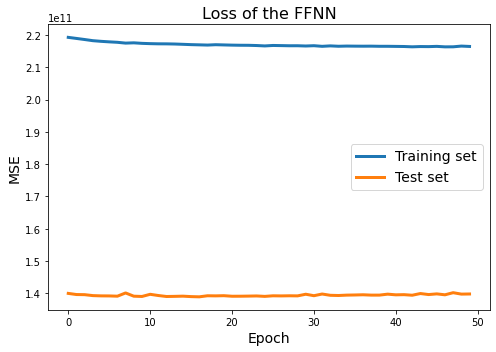

In [ ]:
plt.figure(figsize=(7, 5))
plt.plot(history.epoch, history.history['loss'], lw=3, label='Training set')
plt.plot(history.epoch, history.history['val_loss'], lw=3, label='Test set')
plt.legend(fontsize=14)
plt.title('Loss of the FFNN', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('MSE', fontsize=14)
plt.tight_layout()

La Mean Squared Error est de l'ordre de 10^11, peu importe le nombre d'epochs. Le réseau n'est absolument pas efficace. L'erreur est même plus faible sur le Test set, ce qui est étrange, mais tellement l'erreur est grande cela ne veut plus rien dire.

In [ ]:
pred_train = model.predict(x_train)
print(np.sqrt(mean_squared_error(y_train,pred_train)))

pred = model.predict(x_test)
print(np.sqrt(mean_squared_error(y_test,pred))) 

464837.35950346745
373929.3592720606


On obtient une Root Mean Squared Error de 464 837 m2 sur l'échantillon de train et de 373 929 sur celui de test. 

On obtient des erreurs du même ordre de grandeur avec des arbres de décision/random forest pour prédire la surface brûlée. C'est pour cela qu'on a tenté un réseau de neurones. On ne surcharge pas le notebook avec ces arbres/random forest car c'est quasiment les mêmes codes que pour la classification ci-dessus.

## Deuxième essai : création de nouvelles variables

Comme vu précédemment, le faible nombre de variables considérées est une des raisons pour lesquelles nos modèles ne sont pas satisfaits. 

Dans cette partie, nous tâcherons de créer de nouvelles variables/features qui témoigneront de la propension d'une observation à être un feu de forêt grâce à sa localisation et au mois considéré. Notre étude prend désormais en compte des variables géographiques (et non juste météorologiques).

### **Création des variables**

In [67]:
from datetime import datetime
df = pd.read_csv('data.zip', low_memory = False)

In [68]:
df_feu = df[df["Départ de feu"] == 1]

**Création d'une variable sur le mois** 

L'on va ici chercher à créer une variable quantitative qui rende compte de la "prédisposition" d'un mois à connaître des feux de forêts. Comme on a pu le voir précédemment, il y a empiriquement plus de feux en août qu'en octobre. On cherche donc une variable qui permette d'en témoigner. 

On crée ainsi une variable *Mois propice* qui à chaque observation donne le pourcentage des feux des années précédentes (dans la limite de nos données, c'est-à-dire l'année 2006) s'étant produits durant ce mois de l'année. Plus ce chiffre est élevé, plus ce mois est à risque.

Cette variable s'appuie exclusivement sur les données des années précédentes. La valeur attribuée à chaque mois varie également d'une année à l'autre, car elle prend en compte les feux de l'année qui vient de s'écouler. Ce comptage est intéressant car il gagne en fiabilité d'années en années. 


In [69]:
répartition = []

for année in range(2007,2020) :

    mois, nb_mois_previous_years = np.unique(df_feu['Date de première alerte'][df_feu.Année < année].str[5:7], return_counts=True)
    répartition_previous_years = nb_mois_previous_years / sum(nb_mois_previous_years)

    répartition.append([année,répartition_previous_years])

répartition[0:3]

[[2007, array([0.01557839, 0.03579715, 0.05502154, 0.09214451, 0.09048724,
         0.1528008 , 0.25223732, 0.18362612, 0.06463374, 0.02320186,
         0.02552204, 0.00894929])],
 [2008, array([0.02895404, 0.03184944, 0.07871878, 0.09156714, 0.06858487,
         0.11653999, 0.2062975 , 0.15635179, 0.09989142, 0.06424177,
         0.03999276, 0.0170105 ])],
 [2009, array([0.03337488, 0.06051793, 0.08613765, 0.08932281, 0.06093339,
         0.09735494, 0.19055532, 0.15939621, 0.09901676, 0.07519734,
         0.0340673 , 0.01412547])]]

Le tableau *répartition* indique pour chaque année la proportion par mois des feux déclarés les années précédentes (depuis 2006). 

In [70]:
répartition[4]

[2011, array([0.02136822, 0.0519987 , 0.11594085, 0.08409165, 0.05492363,
        0.09140396, 0.190039  , 0.17907052, 0.10814105, 0.06857329,
        0.02445564, 0.0099935 ])]

Par exemple, entre 2006 et 2010, 2% des feux se sont produits durant les mois de janviers, alors que 19% des feux entre 2006 et 2010 ont été en juillet. 

In [71]:
def mois_propice(date) : 
    "renvoie la proportion des feux déclenchés ce mois-ci les années précédentes"
    date = datetime.strptime(date, '%Y-%m-%d %H:%M:%S')
    month, year = date.month, date.year

    if year > 2006 : 
        return répartition[year-2007][1][month-1]

In [72]:
df['Mois propice'] = df['Date'].apply(lambda row: mois_propice(row))

**Création d'une variable sur la station** 

On crée maintenant une variable qui témoigne de la "prédisposition" d'une zone géographique (représentée par une station) à connaître des feux de forêts. 

On raisonne pareillement que pour la variable *Mois propice* en termes de pourcentage de feux des années précédentes observée par station. 


On ne peut en effet pas : 


*   Compter le nombre de feux par station dans la base, car lorsqu'on utilisera les méthodes de prédiction sur une certaine observation (à une certaine date), cela voudrait dire que l'on utilise les données de dates ultérieures, et donc qu'on connaît l'avenir. 


*   Compter le nombre de feux par station qui se sont produits avant l'observation. Les valeurs prises par une station seraient différentes d'une année à l'autre, et la variable n'aurait alors plus de sens. (Par exemple, on peut imaginer qu'il y ait autant de feu en Haute-Corse en 2006 qu'en Bretagne entre 2006 et 2018 : la valeur prise par la variable *Zone propice* pour une observation en Corse en 2007 serait égale à celle prise par une observation en Bretagne en 2019, ce qui ne rendrait pas bien compte de la réalité lorsqu'on utilisera les techniques de prédiction. 

Considérer les données sur toutes les années précédentes permet de créer une variable plus fiable que si l'on utilisait que celle d'une année précédente.

In [73]:
répartition_zone = []

for année in range(2007,2020) :

    zone, nb_zone = np.unique(df_feu['id_station'][df_feu.Année < année], return_counts=True)
    prop_zone = nb_zone / sum(nb_zone)
    prop_zone_previous = [ [zone[i], prop_zone[i]] for i in range(0,len(zone)) ]
    répartition_zone.append([année,prop_zone_previous])

*répartition_zone* est un tableau donnant, pour chaque année, la proportion de feux s'étant déclarée dans chaque station les années précédentes

In [74]:
#Exemple : la répartition pour l'année 2007
répartition_zone[0][1]

[[7110, 0.0006629101756711965],
 [7130, 0.0019887305270135896],
 [7139, 0.004971826317533974],
 [7149, 0.003646005966191581],
 [7207, 0.0016572754391779914],
 [7222, 0.00033145508783559825],
 [7240, 0.0029830957905203847],
 [7255, 0.0016572754391779914],
 [7280, 0.0009943652635067948],
 [7299, 0.0016572754391779914],
 [7314, 0.003977461054027179],
 [7335, 0.0029830957905203847],
 [7434, 0.011269472986410341],
 [7460, 0.0019887305270135896],
 [7471, 0.008286377195889956],
 [7481, 0.010275107722903546],
 [7510, 0.12595293337752733],
 [7535, 0.03513423931057342],
 [7558, 0.01358965860125953],
 [7577, 0.0573417301955585],
 [7591, 0.005634736493205171],
 [7607, 0.07093138879681803],
 [7621, 0.00033145508783559825],
 [7627, 0.013258203513423931],
 [7630, 0.006297646668876367],
 [7643, 0.04441498176997017],
 [7650, 0.07590321511435201],
 [7661, 0.060656281073914485],
 [7690, 0.07225720914816043],
 [7747, 0.06529665230361285],
 [7761, 0.1537951607557176],
 [7790, 0.13921113689095127],
 [61968,

In [75]:
def zone_propice(date,station) : 
    "renvoie la proportion des feux déclenchés dans cette zone les années précédentes"

    date = datetime.strptime(date, '%Y-%m-%d %H:%M:%S')
    year = date.year
 
    if year > 2006 : 
        ligne = [i for i in range(0,len(répartition_zone[year-2007][1])) if répartition_zone[year-2007][1][i][0] == station]
        #liste des lignes correspondant à l'année et à la station 
        if len(ligne) != 0 :
            #len(ligne) == 1 si la station n'est pas dégénérée (existe dans les données)
            return répartition_zone[year-2007][1][ligne[0]][1]

In [76]:
df['Zone propice'] = df.apply(lambda row: zone_propice(row['Date'], row['id_station']), axis=1)

In [88]:
df['Zone propice']

0         NaN
1         NaN
2         NaN
3         NaN
4         NaN
           ..
2363072   NaN
2363073   NaN
2363074   NaN
2363075   NaN
2363076   NaN
Name: Zone propice, Length: 2363077, dtype: float64

In [86]:
#Exemple d'une station Corse
df[df["id_station"] == 7761][["Date","Zone propice"]].sample(5) 

,Date,Zone propice
1611822,2006-08-19 00:00:00,NaN
1619376,2009-02-24 21:00:00,0.158981
1636268,2014-10-23 15:00:00,0.142842
1618096,2008-09-20 03:00:00,0.165038
1648464,2018-12-20 12:00:00,0.115816


Le raisonnement que l'on va maintenant mener est identique à celui que nous avons eu dans le premier essai. Nous allons comparer les résultats des deux essais, et on s'attend à ce que ce deuxième essai, qui prend en compte davantage de variables, ait de meilleurs résultats. 

### **Préparation des bases d'apprentissage et de test**

In [ ]:
df2 = df.iloc[:, [0,17,18,19,21,22,23,24,25,26]]  
df2 = df2.dropna()

In [ ]:
df2.head()

,Départ de feu,Latitude station,Longitude station,Altitude station,Température (°C),Précipitations (3 heures),Humidité (%),Vitesse du vent (m/s),Mois propice,Zone propice
69920,0,50.57,3.0975,47,7.7,-0.1,86.0,4.1,0.024042,0.000042
69921,0,50.57,3.0975,47,5.4,0.0,87.0,3.3,0.024042,0.000042
69922,0,50.57,3.0975,47,2.7,0.0,96.0,1.4,0.024042,0.000042
69923,0,50.57,3.0975,47,2.7,-0.1,97.0,0.9,0.024042,0.000042
69924,0,50.57,3.0975,47,6.3,0.0,97.0,2.9,0.024042,0.000042


Le dataframe que nous considérons maintenant comporte davantage de variables que celui utilisé précédemment : on a des informations sur la localisation de la station (latitude, longitude et altitude) et sur la prédisposition du mois et de la zone à être victime de feux de forêt. 

In [ ]:
train, test = train_test_split(df2, test_size=0.2, random_state=1)

In [ ]:
X_train = train.drop(['Départ de feu'], axis = 1).to_numpy()
Y_train = train[['Départ de feu']].to_numpy()

X_test = test.drop(['Départ de feu'], axis = 1).to_numpy()
Y_test = test[['Départ de feu']].to_numpy()

Y_train = Y_train.reshape(Y_train.shape[0])
Y_test = Y_test.reshape(Y_test.shape[0])

### **Modèle 1 : l'arbre de décision**

**Entraînement**

In [ ]:
#instanciation de l'arbre
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier()

#construction de l'arbre
tree = tree.fit(X_train, Y_train)

**Evaluation**

In [ ]:
tree_predict_test = tree.predict(X_test)

Comme l'on a pu le voir précédemment, les taux de reconnaissance et d'erreur du modèle peuvent être trompeurs du fait de la faible proportion d'observations correspondant à un feu de forêt. On s'intéressera donc principalement au rapport de prédiction. 

In [ ]:
print('Rapport de prédiction sur la base de test :')
print(classification_report(Y_test, tree_predict_test))

Rapport de prédiction sur la base de test :
              precision    recall  f1-score   support

           0       0.99      0.98      0.98    282442
           1       0.30      0.39      0.34      6004

    accuracy                           0.97    288446
   macro avg       0.65      0.68      0.66    288446
weighted avg       0.97      0.97      0.97    288446



In [ ]:
#calcul de la matrice de confusion 
print('Matrice de confusion')
confu_tree = confusion_matrix(Y_test,tree_predict_test)
print(confu_tree)  

Matrice de confusion
[[277111   5331]
 [  3672   2332]]


On observe encore une fois une très bonne performance du modèle sur les observations ne correspondant pas à un feu de forêt. 

En ce qui concerne les observations correspondant à un feu de forêt (*Départ de feu* == 1), le modèle affiche de meilleures performances en précision et en recall. Cela est encourageant, néanmoins nous sommes encore loin d'une prédiction satisfaisante.

Nous sommes passés de 1337 vrais positifs (1er arbre de décision) à 2345 ! C'est déjà mieux. Le recall est passé de 0.2 à 0.39 !

### **Modèle 2 : Random forest**

Le modèle *Random Forest* est censé nous livrer de meilleurs résultats qu'un arbre de décision seul.

**Entraînement**

In [ ]:
#Attention : cellule longue à exécuter
rfc = RandomForestClassifier()
rfc = rfc.fit(X_train, Y_train)

**Evaluation**

In [ ]:
rfc_predict_test = rfc.predict(X_test)

In [ ]:
#calcul de la matrice de confusion 
print('Matrice de confusion')
confu_rfc = confusion_matrix(Y_test,rfc_predict_test)
print(confu_rfc)  

Matrice de confusion
[[281983    459]
 [  4202   1802]]


In [ ]:
print('Rapport de prédiction sur la base de test :')
print(classification_report(Y_test, rfc_predict_test))

Rapport de prédiction sur la base de test :
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    282442
           1       0.80      0.30      0.44      6004

    accuracy                           0.98    288446
   macro avg       0.89      0.65      0.71    288446
weighted avg       0.98      0.98      0.98    288446



Notre travail commence à porter ses fruits : 

Le modèle *Random Forest* a une excellente performance sur les observations ne correspondant pas à un feu de forêt. 

Concernant les observations correspondant à un feu de forêt, la précision s'est grandement améliorée et commence à devenir intéressante. La part de faux positifs a diminué ( $ = 1 - precision_1 $), comme on peut l'obverser sur la matrice de confusion (cellule 1,1). Le modèle arrive à mieux reconnaître les observations ne correspondant pas à un feu de forêt. 

Néanmoins, $recall_1$ demeure faible : le modèle a des difficultés à reconnaître lorsqu'une observation correspond à un feu de forêt. Ce recall est même mieux avec l'arbre de décision (0.39) qu'avec la random forest (0.29).




### **Modèle 3 :**

Dans cette toute dernière partie on retest le réseau de neurones avec les nouvelles features.

On va même ajouter 2 nouvelles features qui étaient beaucoup trop longues à faire tourner sur la base de données avec tous les relevés météo. Ici, on s'intéresse seulement aux relevés avec départ de feu.

Ces 2 nouvelles features sont "la quantité moyenne de précipitation de la semaine précédent le relevé" et "la moyenne de température des deux semaines précédent le relevé".

On garde les mêmes features que précédemment et seulement les lignes sans valeurs manquantes et où il y a eu départ de feu (grâce au dropna).

On crée une variable nous donnant la quantité moyenne de précipitation de la semaine précédent le relevé.

Comme il y a des relevés toutes les 3 heures, une semaine correspond à 56 relevés. Pour chaque ligne, on somme donc sa quantité de précipitation avec les 55 précédentes (la base est déjà ordonnée par date). Cela signifie qu'il faudra ignorer la première semaine des données, ce qui n'est pas dramatique étant donnée la taille de base. On fait cela pour chaque station.



Attention : la création de ces 2 nouvelles features sont longues à exécuter.

In [49]:
df

,Départ de feu,Année,Date de première alerte,Département,Commune,Code postal,Code INSEE,Latitude commune,Longitude commune,Surface brûlée (m2),Surface forêt (m2),Surface autres terres boisées (m2),Surfaces non boisées naturelles (m2),Surfaces non boisées artificialisées (m2),Surfaces non boisées (m2),Nom station,id_station,Latitude station,Longitude station,Altitude station,Date,Température (°C),Précipitations (3 heures),Humidité (%),Vitesse du vent (m/s),Mois propice,Zone propice
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ABBEVILLE,7005,50.136000,1.834,69,2006-01-01 00:00:00,4.0,2.0,92.0,5.1,NaN,NaN
1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ABBEVILLE,7005,50.136000,1.834,69,2006-01-01 03:00:00,3.7,0.0,91.0,4.1,NaN,NaN
2,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ABBEVILLE,7005,50.136000,1.834,69,2006-01-01 06:00:00,3.1,3.0,92.0,5.1,NaN,NaN
3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ABBEVILLE,7005,50.136000,1.834,69,2006-01-01 09:00:00,4.7,0.6,96.0,3.1,NaN,NaN
4,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ABBEVILLE,7005,50.136000,1.834,69,2006-01-01 12:00:00,6.1,2.0,94.0,5.1,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2363072,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DUMONT D'URVILLE,89642,-66.663167,140.001,43,2019-12-31 00:00:00,0.7,NaN,62.0,28.3,0.016747,NaN
2363073,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DUMONT D'URVILLE,89642,-66.663167,140.001,43,2019-12-31 12:00:00,1.7,NaN,74.0,23.1,0.016747,NaN
2363074,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DUMONT D'URVILLE,89642,-66.663167,140.001,43,2019-12-31 15:00:00,1.0,NaN,78.0,18.0,0.016747,NaN
2363075,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DUMONT D'URVILLE,89642,-66.663167,140.001,43,2019-12-31 18:00:00,1.0,NaN,72.0,20.6,0.016747,NaN


In [53]:
df['Zone propice'].iloc[456:470]

456   NaN
457   NaN
458   NaN
459   NaN
460   NaN
461   NaN
462   NaN
463   NaN
464   NaN
465   NaN
466   NaN
467   NaN
468   NaN
469   NaN
Name: Zone propice, dtype: float64

In [89]:
import math
from tqdm import tqdm
tqdm.pandas()
df['Index']=df.index
df_feu=df[df['Départ de feu']==1]
df_feu['Index']=df_feu.index

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [90]:
def moyenne_precipitations(index):
    if math.isnan(df.iloc[index,16]):
        return np.nan
    sub = df[df['id_station'] == df.iloc[index,16]]  #on se restreint aux relevés d'une même station. La base est ordonnée par station donc les index restent dans le bon ordre et se suivent
    if index >= 55 and index+1 <= df.shape[0]:
        sub = sub[sub['Index'].between(index-54,index+1)]        #on garde prend les 55 relevés précédents
        return sub['Précipitations (3 heures)'].sum(axis=0)/56   #on fait la moyenne pour les relevés pertinents
    else:
        return np.nan   #pour les premier relevés, on ne peut pas avoir la moyenne de la semaine précédente, la valeur est NaN

In [91]:
df_feu['Précipitation semaine'] = df_feu['Index'].progress_apply(lambda row: moyenne_precipitations(row))

100%|██████████| 33080/33080 [06:49<00:00, 80.81it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


On crée également une variable nous donnant la moyenne de température des deux semaines précédent le relevé (moyenne avec les 111 relevés précedents donc).

In [92]:
def moyenne_temperature(index):
    if math.isnan(df.iloc[index,16]):
        return np.nan
    sub = df[df['id_station'] == df.iloc[index,16]]  #on se restreint aux relevés d'une même station. La base est ordonnée par station donc les index restent dans le bon ordre et se suivent
    if index >= 111 and index+1 <= df.shape[0]:
        sub = sub[sub['Index'].between(index-110,index+1)]        #on garde prend les 111 relevés précédents
        return sub['Température (°C)'].sum(axis=0)/112   #on fait la moyenne pour les relevés pertinents
    else:
        return np.nan   #pour les premier relevés, on ne peut pas avoir la moyenne de la semaine précédente, la valeur est NaN

In [93]:
df_feu['Température semaine'] = df_feu['Index'].progress_apply(lambda row: moyenne_temperature(row))

100%|██████████| 33080/33080 [06:57<00:00, 79.32it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [94]:
df_feu

,Départ de feu,Année,Date de première alerte,Département,Commune,Code postal,Code INSEE,Latitude commune,Longitude commune,Surface brûlée (m2),Surface forêt (m2),Surface autres terres boisées (m2),Surfaces non boisées naturelles (m2),Surfaces non boisées artificialisées (m2),Surfaces non boisées (m2),Nom station,id_station,Latitude station,Longitude station,Altitude station,Date,Température (°C),Précipitations (3 heures),Humidité (%),Vitesse du vent (m/s),Mois propice,Zone propice,Index,Précipitation semaine,Température semaine
68054,1,2015.0,2015-05-12 16:17:00,02,LE NOUVION EN THIERACHE,02170,02558,50.01670,3.78333,1000.0,1000.0,0.0,0.0,0.0,0.0,LILLE-LESQUIN,7015,50.570000,3.097500,47,2015-05-12 15:00:00,18.3,0.0,44.0,8.8,0.061103,NaN,68054,0.007143,13.246429
88139,1,2008.0,2008-04-16 19:16:00,50,BESNEVILLE,50390,50049,49.36670,-1.63333,40000.0,0.0,20000.0,20000.0,0.0,20000.0,PTE DE LA HAGUE,7020,49.725167,-1.939833,6,2008-04-16 18:00:00,10.0,0.0,63.0,7.2,0.091567,NaN,88139,0.057143,8.213393
99242,1,2012.0,2012-04-03 15:21:00,50,LESSAY,50430,50267,49.21670,-1.53333,100000.0,0.0,100000.0,0.0,0.0,0.0,PTE DE LA HAGUE,7020,49.725167,-1.939833,6,2012-04-03 15:00:00,11.4,0.0,78.0,4.1,0.089479,0.000067,99242,0.007143,9.307143
103316,1,2013.0,2013-08-28 21:39:00,50,LESSAY,50430,50267,49.21670,-1.53333,1000.0,0.0,1000.0,0.0,0.0,0.0,PTE DE LA HAGUE,7020,49.725167,-1.939833,6,2013-08-28 21:00:00,11.4,0.0,90.0,0.0,0.165589,0.000114,103316,0.064286,16.840179
113680,1,2017.0,2017-04-09 17:18:00,50,PIROU,50770,50403,49.18330,-1.58333,6800.0,6800.0,0.0,0.0,0.0,0.0,PTE DE LA HAGUE,7020,49.725167,-1.939833,6,2017-04-09 18:00:00,11.1,0.0,86.0,6.4,0.083454,0.000114,113680,0.058929,11.050893
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1722201,1,2018.0,2018-10-26 00:30:00,974,SAINT DENIS,97490,97411,1.71819,46.71070,300.0,0.0,300.0,0.0,0.0,0.0,GLORIEUSES,61968,-11.582667,47.289667,3,2018-10-26 00:00:00,25.1,0.0,75.0,4.5,0.068166,0.002772,1722201,0.000000,26.829464
1722276,1,2018.0,2018-11-04 17:16:00,974,SAINT DENIS,97490,97411,1.71819,46.71070,100.0,0.0,100.0,0.0,0.0,0.0,GLORIEUSES,61968,-11.582667,47.289667,3,2018-11-04 18:00:00,25.2,0.0,83.0,0.0,0.025471,0.002772,1722276,0.517857,26.858036
1724477,1,2019.0,2019-08-21 08:05:00,974,SAINT DENIS,97490,97411,1.71819,46.71070,1541.0,1541.0,0.0,0.0,0.0,0.0,GLORIEUSES,61968,-11.582667,47.289667,3,2019-08-21 09:00:00,26.7,0.0,75.0,1.6,0.176923,0.003448,1724477,0.085714,25.544643
1725083,1,2019.0,2019-11-11 14:24:00,974,SAINT DENIS,97490,97411,1.71819,46.71070,3835.0,0.0,3835.0,0.0,0.0,0.0,GLORIEUSES,61968,-11.582667,47.289667,3,2019-11-11 15:00:00,27.1,0.0,74.0,2.4,0.024693,0.003448,1725083,0.000000,28.022321


In [97]:
df3 = df_feu.iloc[:, [9,17,18,19,21,22,23,24,25,26,28,29]]  
df3 = df3.dropna()
df3.head()


,Surface brûlée (m2),Latitude station,Longitude station,Altitude station,Température (°C),Précipitations (3 heures),Humidité (%),Vitesse du vent (m/s),Mois propice,Zone propice,Précipitation semaine,Température semaine
99242,100000.0,49.725167,-1.939833,6,11.4,0.0,78.0,4.1,0.089479,0.000067,0.007143,9.307143
103316,1000.0,49.725167,-1.939833,6,11.4,0.0,90.0,0.0,0.165589,0.000114,0.064286,16.840179
113680,6800.0,49.725167,-1.939833,6,11.1,0.0,86.0,6.4,0.083454,0.000114,0.058929,11.050893
113740,2000.0,49.725167,-1.939833,6,10.8,0.0,89.0,5.0,0.083454,0.000114,0.007143,10.828571
117143,800.0,49.725167,-1.939833,6,16.0,0.0,66.0,4.0,0.091385,0.000173,0.000000,14.475893


In [99]:
values=df3.values
x = values[:,[1,2,3,4,5,6,7,8,9,10,11]].astype(float)
y = values[:,0].astype(float)

In [100]:
x_train,x_test,y_train,y_test = train_test_split(x, y, test_size = 0.3, random_state = 10)

In [101]:
x_train.shape

(20828, 11)

In [102]:
model = Sequential()

model.add(Dense(500, input_dim = x_train.shape[1], activation = 'relu'))
model.add(Dense(100, activation = 'relu'))
model.add(Dense(50, activation = 'relu'))
model.add(Dense(1))

model.compile(loss = "mean_squared_error" , optimizer = "adam", metrics = ["mean_squared_error"])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 500)               6000      
_________________________________________________________________
dense_1 (Dense)              (None, 100)               50100     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 61,201
Trainable params: 61,201
Non-trainable params: 0
_________________________________________________________________


In [103]:
history = model.fit(x_train, y_train, epochs = 50, verbose = 1, validation_data=(x_test, y_test))

Epoch 1/50
651/651 [==============================] - 2s 3ms/step - loss: 264185593856.0000 - mean_squared_error: 264185593856.0000 - val_loss: 93453410304.0000 - val_mean_squared_error: 93453410304.0000
Epoch 2/50
651/651 [==============================] - 2s 2ms/step - loss: 263814135808.0000 - mean_squared_error: 263814135808.0000 - val_loss: 93349453824.0000 - val_mean_squared_error: 93349453824.0000
Epoch 3/50
651/651 [==============================] - 1s 2ms/step - loss: 263561707520.0000 - mean_squared_error: 263561707520.0000 - val_loss: 93250895872.0000 - val_mean_squared_error: 93250895872.0000
Epoch 4/50
651/651 [==============================] - 1s 2ms/step - loss: 263341572096.0000 - mean_squared_error: 263341572096.0000 - val_loss: 92950028288.0000 - val_mean_squared_error: 92950028288.0000
Epoch 5/50
651/651 [==============================] - 1s 2ms/step - loss: 262963740672.0000 - mean_squared_error: 262963740672.0000 - val_loss: 92841566208.0000 - val_mean_squared_erro

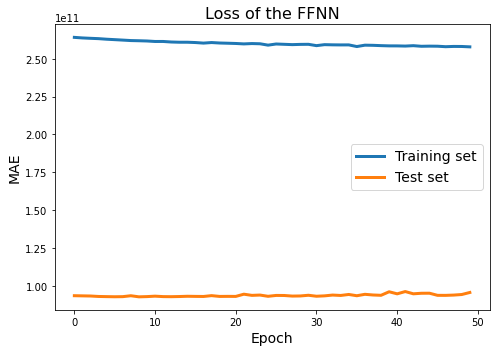

In [104]:
plt.figure(figsize=(7, 5))
plt.plot(history.epoch, history.history['loss'], lw=3, label='Training set')
plt.plot(history.epoch, history.history['val_loss'], lw=3, label='Test set')
plt.legend(fontsize=14)
plt.title('Loss of the FFNN', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('MAE', fontsize=14)
plt.tight_layout()

In [105]:
pred_train = model.predict(x_train)
print(np.sqrt(mean_squared_error(y_train,pred_train)))

pred = model.predict(x_test)
print(np.sqrt(mean_squared_error(y_test,pred))) 

506873.456143606
309164.6300294087


On a toujours des erreurs considérables malgré les nouvelles features.
